In [26]:
import os
import numpy as np
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv
import pickle

%matplotlib inline


In [22]:
img1 = cv.imread(("/dasio/AI5758/snapshots/snapshots-2021-09-05/img-2021-09-05T09-08-46devID1.jpg"), cv.COLOR_BGR2RGB)
img2 = cv.imread(("/dasio/AI5758/snapshots/snapshots-2021-09-05/img-2021-09-05T09-08-46devID2.jpg"), cv.COLOR_BGR2RGB)
img_mask1 = cv.imread(("./SIFT/mask100.jpg"),0)
img_mask2 = cv.imread(("./SIFT/mask100.jpg"),0)


In [32]:
def SIFT_detect(img1, img2):
    sift = cv.SIFT_create()
    kp1, dst1 = sift.detectAndCompute(img1, None)
    kp2, dst2 = sift.detectAndCompute(img2, None)
    kp1_filtered = [
        list_element for list_element in kp1 if condition(list_element.pt)]
    dst1_filtered = np.array(
        [dsc for (dsc, kp) in zip(dst1, kp1) if condition(kp.pt)])
    kp2_filtered = [
        list_element for list_element in kp2 if condition(list_element.pt)]
    dst2_filtered = np.array(
        [dsc for (dsc, kp) in zip(dst2, kp2) if condition(kp.pt)])
    bf = cv.BFMatcher.create(cv.NORM_L2)
    matches = bf.knnMatch(dst1_filtered, dst2_filtered, k=1)
    #result = cv.drawMatchesKnn(img1, kp1_filtered, img2, kp2_filtered, matches, flags = 2,  outImg=None)
    return kp1_filtered, kp2_filtered, matches


# условие для фильтрации наиболее близких точек к центру фотоснимка
def condition(list_with_coord):
    return np.sqrt((list_with_coord[0]-960)**2+(list_with_coord[1]-960)**2) <= 500


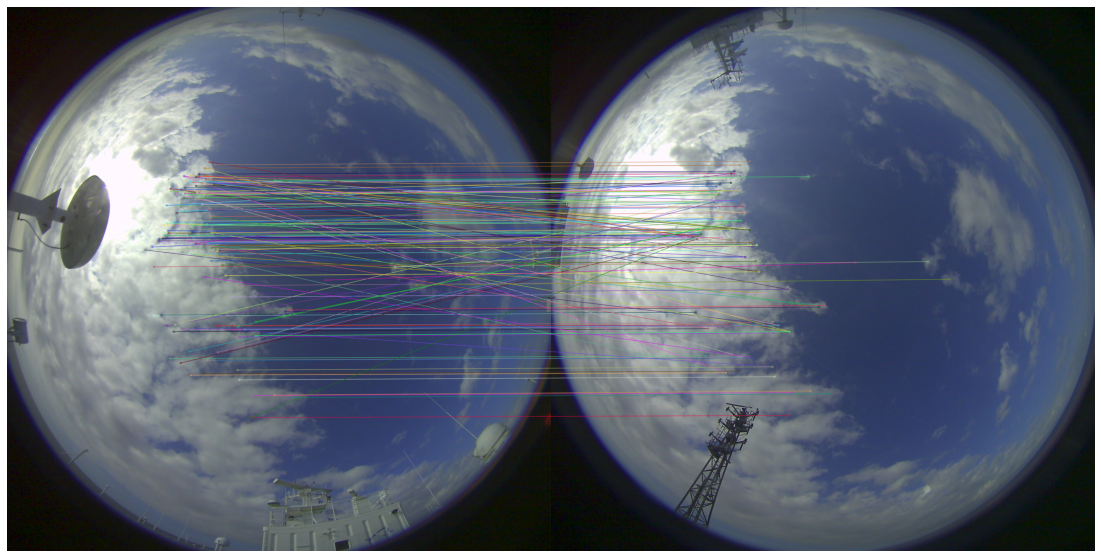

In [27]:
#result = cv.drawMatchesKnn(img1, kp1_filtered, img2, kp2_filtered, matches, flags = 2,  outImg=None)
kp1_filtered, kp2_filtered, matches = SIFT_detect(img1, img2)
result = cv.drawMatchesKnn(img1, kp1_filtered, img2, kp2_filtered, matches, flags = 2,  outImg=None)
result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
cv.calcHist()
plt.rcParams['figure.figsize'] = [20.0, 10.0]
#plt.title('Best Matching Points')
plt.axis('off')
plt.imshow(result)
plt.show()

1. каким образом  cv.BFMatcher.create(cv.NORM_L2) работает
2. количество соседей  bf.knnMatch(dst1_filtered, dst2_filtered, k=1) К = 2,3?
3. гистограмма расстояний между совпадающими точками в пикселях
4.  cv2.distanceTransform - фильтровать на близость к маске


In [31]:
# отсев нескольких точек по дистанции между векторами дескрипторов

    # correct_matches = []
    # for m, n in matches:
    #     if m.distance < 0.75*n.distance:
    #         correct_matches.append([m])
    #         correct_matches_dct[image.split('.')[0]]


# cv2.distanceTransform - фильтровать на близость к маске

# $$H =   \frac{L}{\alpha} = \frac {L}{\frac{S \pi}{1920}} = \frac{1920L}{S \pi}$$
L - расстояние между камерами
S - расстояние между ключевыми точками после преобразования координат
# L = 33,70933727 Метра

# $$ \alpha  = \frac {180^{\circ} * S}{1920} * \frac{\pi}{180^{\circ}} = \frac{S \pi}{1920}$$

In [14]:
trasnformation_matrix = np.array([[np.cos(3.02474397e-09), -np.sin(3.02474397e-09), 1.04715269e-06], [np.sin(3.02474397e-09), np.cos(3.02474397e-09), -2.81405565e-06], [0, 0, 1]])
trasnformation_matrix

array([[ 1.00000000e+00, -3.02474397e-09,  1.04715269e-06],
       [ 3.02474397e-09,  1.00000000e+00, -2.81405565e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [29]:
trasnformation_matrix = np.array([[np.cos(3.02474397e-09), -np.sin(3.02474397e-09), 1.04715269e-06], [np.sin(3.02474397e-09), np.cos(3.02474397e-09), -2.81405565e-06], [0, 0, 1]])
array_coord_old = np.array([list_element.pt for list_element in kp1_filtered])
array_coord_old = np.concatenate([array_coord_old, np.ones((len(array_coord_old), 1))], axis = 1)
new_coord_matrix = np.dot(trasnformation_matrix, array_coord_old.T).T


array_idx_1to2 = np.array([list_element[0].trainIdx for list_element in matches])
sorted_coord1 = np.array([list_element.pt for list_element in kp1_filtered])
sorted_coord2 = np.array([kp2_filtered.pt for (array_idx_1to2, kp2_filtered) in zip(array_idx_1to2, kp2_filtered)])


difference = sorted_coord1 - sorted_coord2
distance =np.array([])
for i in range(sorted_coord1.shape[0]):
    distance = np.append(distance, np.linalg.norm(difference.T[0], difference.T[1] ))
H = distance*(1920*33.70933727) # ghjdthbnm

#sorted_coord1.shape, sorted_coord2.shape

ValueError: operands could not be broadcast together with shapes (162,2) (130,2) 

In [252]:
sorted_coord1 = sorted_coord1[0:127]
sorted_coord1.shape
sorted_coord1[0], sorted_coord1[0]


(array([488.29354858, 857.30834961]), array([488.29354858, 857.30834961]))

In [294]:
np.histogram(H2, bins=10, range=None, normed=None, weights=None, density=None)

(array([97, 21,  3,  1,  2,  2,  0,  0,  0,  1]),
 array([  17.15222311,  217.36893665,  417.5856502 ,  617.80236375,
         818.01907729, 1018.23579084, 1218.45250439, 1418.66921793,
        1618.88593148, 1819.10264503, 2019.31935858]))

In [ ]:
x = np.percentile(H, [5,95])
H_filtered = np.array([H for H in H if x[0]<=H<=x[1] ])
# histogram on linear scale
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.hist(H_filtered,bins = 100)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale..logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(H_filtered,bins = 100)
plt.xscale('log')
plt.show()

NameError: name 'H' is not defined